<img src="REcoM.png" alt="Drawing" style="width: 900px; margin: 0 auto">
<p style="text-align: center;">This notebook is an extensive demonstration of the *py_recom* module. *py_recom* is a tool for the evaluation of REcoM model outputs.</p>

### Table of Contents

* [0. Configuration](#CONFIG)
    * [0.1 Mesh visualization](#MESH)
* [1. Physical fields](#PHYSICS)
    * [1.1 Maps](#PHYMAPS)
        * [1.1.1 Temperature](#TEMPMAPS)
            * [1.1.1.1 PHC3](#TEMPPHC3MAPS)
            * [1.1.1.2 WOA](#TEMPWOAMAPS)
        * [1.1.2 Salinity](#SAL)
            * [1.2.1.1 PHC3](#SALPHC3MAPS)
            * [1.2.1.2 WOA](#SALWOAMAPS)
        * [1.1.3 MLD](#MLD)
    * [1.2 T-S Profiles](#PHYPRO)
    * [1.3 time-series](#PHYTS)

# 0. Configuration<a class="anchor" id="CONFIG"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import socket
import sys
import os
home = os.path.expanduser("~")
sys.path.append(home+'/py_f2recom/GlobalAssessment/') # This suppose that you git cloned the repository in your home, change otherwise
sys.path.append(home+ '/py_f2recom/modules/')
sys.path.append(home+ '/py_f2recom/modules/pyfesom2')
sys.path.append(home+ '/py_f2recom/modules/cmocean-master/')
sys.path.append(home+'/py_f2recom/modules/SkillMetrics/')
import pyfesom2 as pf
import skill_metrics as sm
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset

Autosaving every 5 seconds
osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
#    Only modify parameters and paths in this cell       #
#  In principle, you don't have to modify anything else  #


# run specification -------------------------------------------------------------------------------------   
simu_name = 'A' # only usefull if you want to save figures

# defines paths ----------------------------------------------------------------------------------------- 

if socket.gethostname()[:5] == 'blogi':
    meshpath = '/scratch/usr/hbkoziel/mesh/farc'
    resultpath = '/scratch/projects/hbk00083/model_outputs/fesom2.1_recom'+simu_name+'/'
    savepath = home+'/pyfesom2/codes/py_f2recom_develop/outputs/'+simu_name+'/'
    evalpath      = '/scratch/usr/hbkoziel/evaluation/'
    evalpath2      = '/scratch/usr/hbkoziel/corrected_input/'
elif socket.gethostname()[:5] in ['albed','prod-']:
    #resultpath = '/albedo/work/projects/p_bio/model_output/A_riv'
    resultpath = '/albedo/work/projects/MarESys/GCB2022/A'
    savepath = home+'/py_f2recom/outputs/'+simu_name+'/'
    evalpath = '/albedo/work/projects/p_pool_recom/eval/'
    meshpath = '/albedo/work/projects/p_bio/mesh/core2/'
    #meshpath = '/albedo/work/user/yye/fesom2/meshes/core2_albedo/'
else:
    print('sorry, machine unknown, please customize your paths yourself')

# period of analysis ------------------------------------------------------------------------------------
first_year_maps = 2012
first_year = 2012
last_year  = 2021
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(first_year_maps,last_year+1,1)

# specification of analysis ------------------------------------------------------------------------------------
layerwise = False
depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
uplow = [0, 100]
mapproj = 'rob'
# Map projection ptions are : Mercator (merc), Plate Carree (pc),
# North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
# Robinson projection is quite time consuming.

In [3]:
# export of analysis ------------------------------------------------------------------------------------
# Be aware that exporting figures may alter (crop) the display but the printed figures are okay
# This is because of bugs in the 'constrained_layout' matplotlib experimental function 
# that may be fixed in the future matplotlib version but out of our control
# If you prefer having a nice HTML, savefig must be turned off
#--------------------------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")
savefig = True 
htmlname     =  simu_name+'_'+ today +'_ocean_ice.html'
htmlpath = savepath
verbose = True

if not os.path.exists(htmlpath): # create folders if do not exist
    os.makedirs(htmlpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
# initialization file specifications -----------------------------------------------------------
ncfileTemp               = evalpath+'data/woa18_decav_t00_01_fesom2.nc'
ncfileSal                = evalpath+'data/woa18_decav_s00_01_fesom2.nc'
ncfilePHC3               = evalpath+'phc3.0_annual.nc'      
matfileMLD               = evalpath+'GlobalML_Climato_1970_2018.mat'
ncfilesic                = evalpath+'NSIDC/*.csv'

# visual check
if(verbose):
    print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
        resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))
    print('\nLast ten years are \n{0}'.format(years_last10))
    
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)
mesh.path = meshpath

# export toolbox
!jupyter nbconvert --to=python Py_f2recom_toolbox.ipynb

Processing years 2012 to 2021

Reading out of /albedo/work/projects/MarESys/GCB2022/A
Storing graphs to /albedo/home/loziel/py_f2recom/outputs/A/
Storing html to /albedo/home/loziel/py_f2recom/outputs/A/ as A__2024_02_19_ocean_ice.html

Last ten years are 
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
/albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
[NbConvertApp] Converting notebook Py_f2recom_toolbox.ipynb to python
[NbConvertApp] Writing 48324 bytes to Py_f2recom_toolbox.py


## 0.1 Mesh visualization<a class="anchor" id="MESH"></a>

[NbConvertApp] Converting notebook Py_f2recom_toolbox.ipynb to python
[NbConvertApp] Writing 48324 bytes to Py_f2recom_toolbox.py


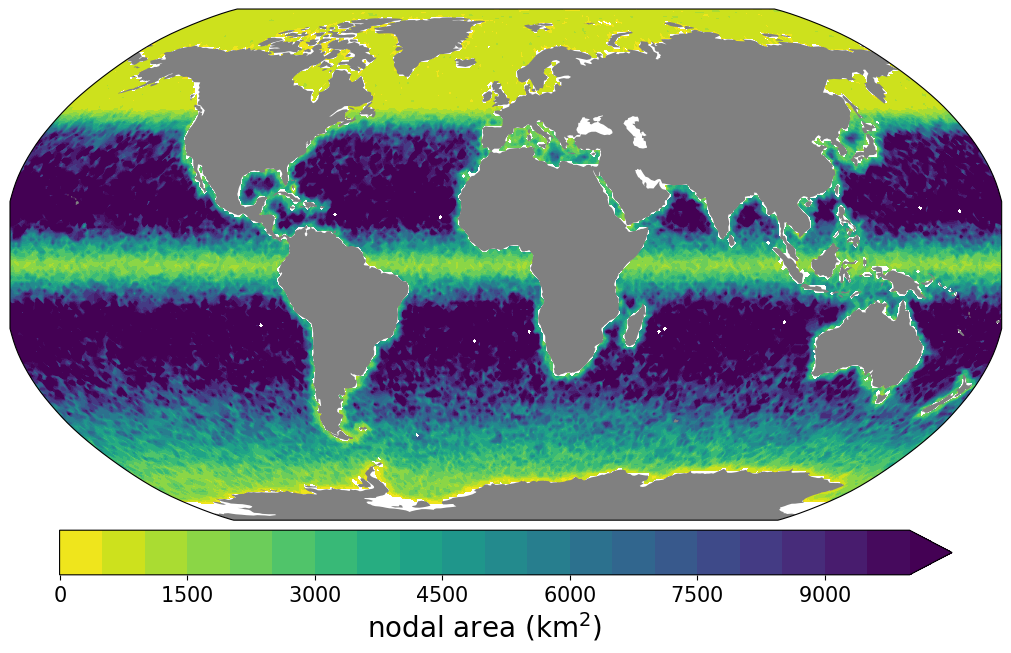

In [4]:
!jupyter nbconvert --to=python Py_f2recom_toolbox.ipynb
from Py_f2recom_toolbox import plot_mesh_area

plot_mesh_area(mesh, plot_globe = True, plot_poles=False, plot_zoom=False, levels=np.arange(0,10500,500))

[NbConvertApp] Converting notebook Py_f2recom_toolbox.ipynb to python
[NbConvertApp] Writing 48324 bytes to Py_f2recom_toolbox.py


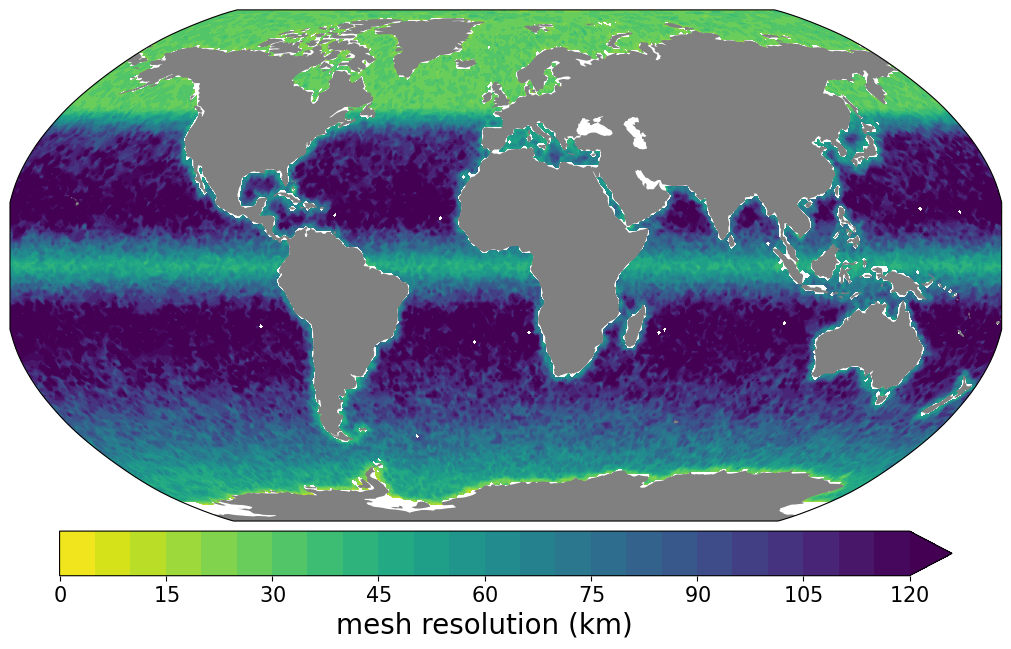

In [5]:
!jupyter nbconvert --to=python Py_f2recom_toolbox.ipynb
from Py_f2recom_toolbox import plot_mesh_resolution

plot_mesh_resolution(mesh, plot_globe = True, plot_poles=False, levels=np.arange(0,125,5))

# 1. Physical fields<a class="anchor" id="PHYSICS"></a>

# 2.1 Maps<a class="anchor" id="PHYMAPS"></a>

# 2.1.1 Temperature<a class="anchor" id="TEMPMAPS"></a>

#### PHC3<a class="anchor" id="TEMPPHC3MAPS"></a>

[NbConvertApp] Converting notebook TS_PHC3.ipynb to python
[NbConvertApp] Writing 49654 bytes to TS_PHC3.py
[NbConvertApp] Converting notebook load_interp_PHC.ipynb to python
[NbConvertApp] Writing 6771 bytes to load_interp_PHC.py
***
Loading PHC file: /albedo/work/projects/p_pool_recom/eval/phc3.0_annual.nc
***
***
Depth greater in FESOM (-6125.0) than in PHC (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 9.9099, std = 10.5479, min = -1.8405, max = 29.2068
WOA mean = 9.9082, std = 10.6631, min = -1.8534, max = 29.2138


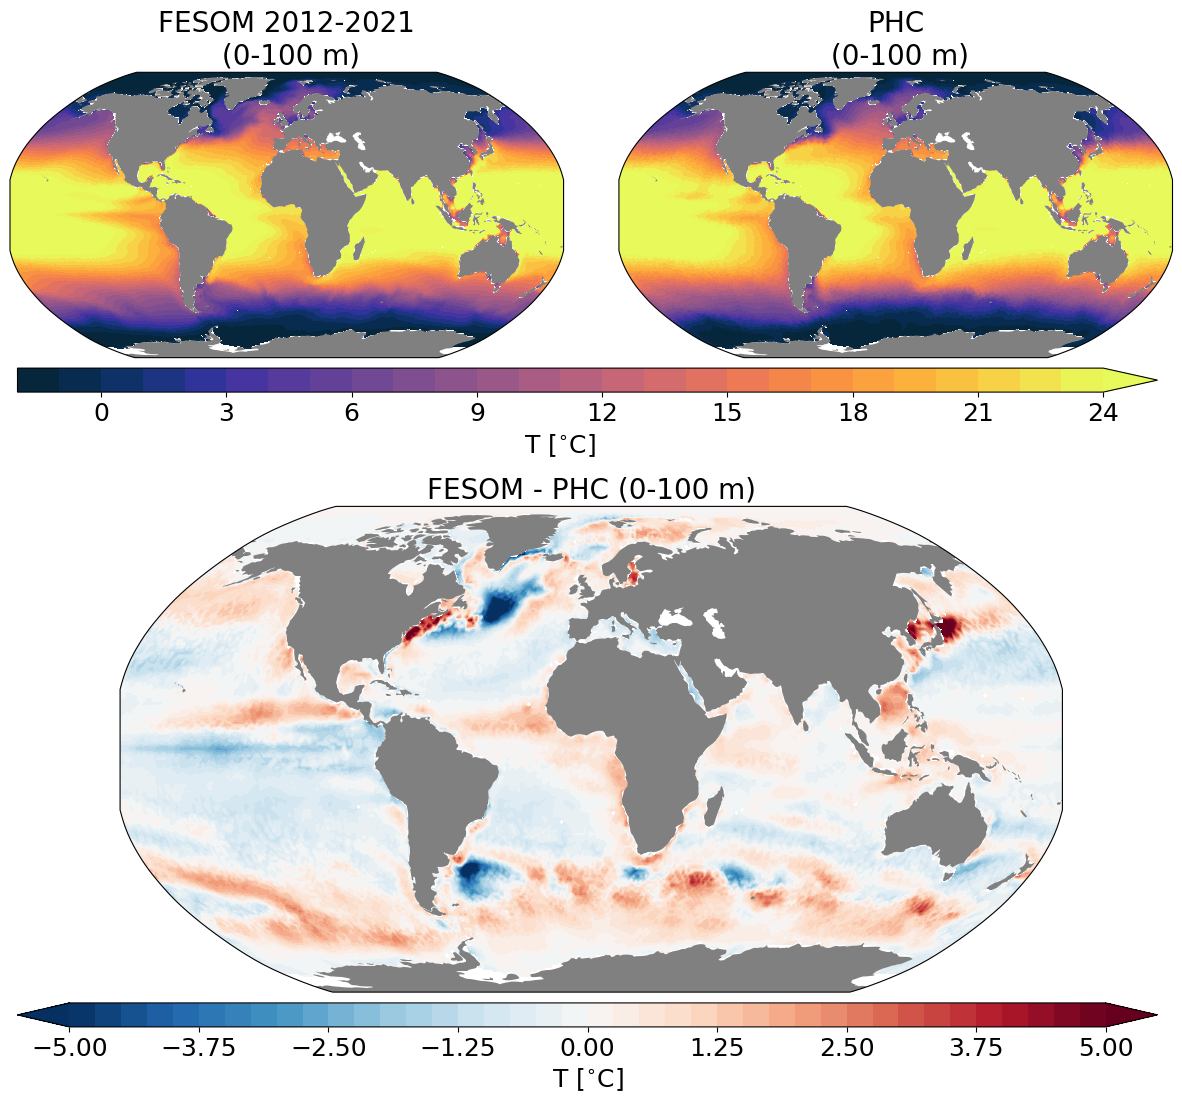


Original Taylor stats:
SDEV pred: 10.54785, ref: 10.66315
CRMS pred: 0.93631, ref: 0.00000
CORRCOEF: 0.99616

Normalized Taylor stats:
SDEV pred: 0.98919, ref: 1.00000
CRMS pred: 0.08781, ref: 0.00000
CORRCOEF: 0.99616


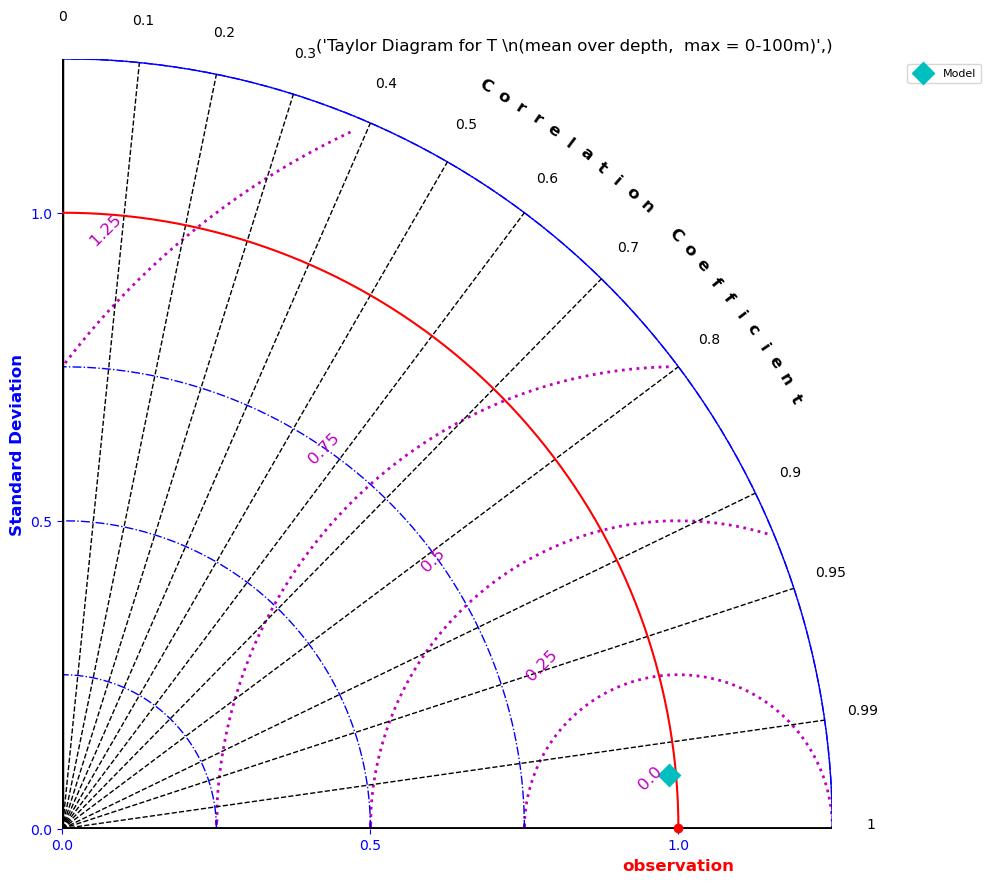

In [4]:
!jupyter nbconvert --to=python TS_PHC3.ipynb
!jupyter nbconvert --to=python load_interp_PHC.ipynb

from TS_PHC3 import PHC3tempcomp
PHC3tempcomp(resultpath,savepath,mesh,ncfilePHC3,first_year_maps,last_year,
                layerwise=layerwise,depth_array=0,savefig=savefig, 
                cmap = cmo.cm.thermal,verbose=verbose)

#### WOA<a class="anchor" id="TEMPWOAMAPS"></a>

[NbConvertApp] Converting notebook Temp_WOA.ipynb to python
[NbConvertApp] Writing 16372 bytes to Temp_WOA.py
[NbConvertApp] Converting notebook load_interp_WOA.ipynb to python
[NbConvertApp] Writing 7253 bytes to load_interp_WOA.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_decav_t00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 9.9099, std = 10.5479, min = -1.8405, max = 29.2068
WOA mean = 9.8969, std = 10.6052, min = -1.8620, max = 29.1537


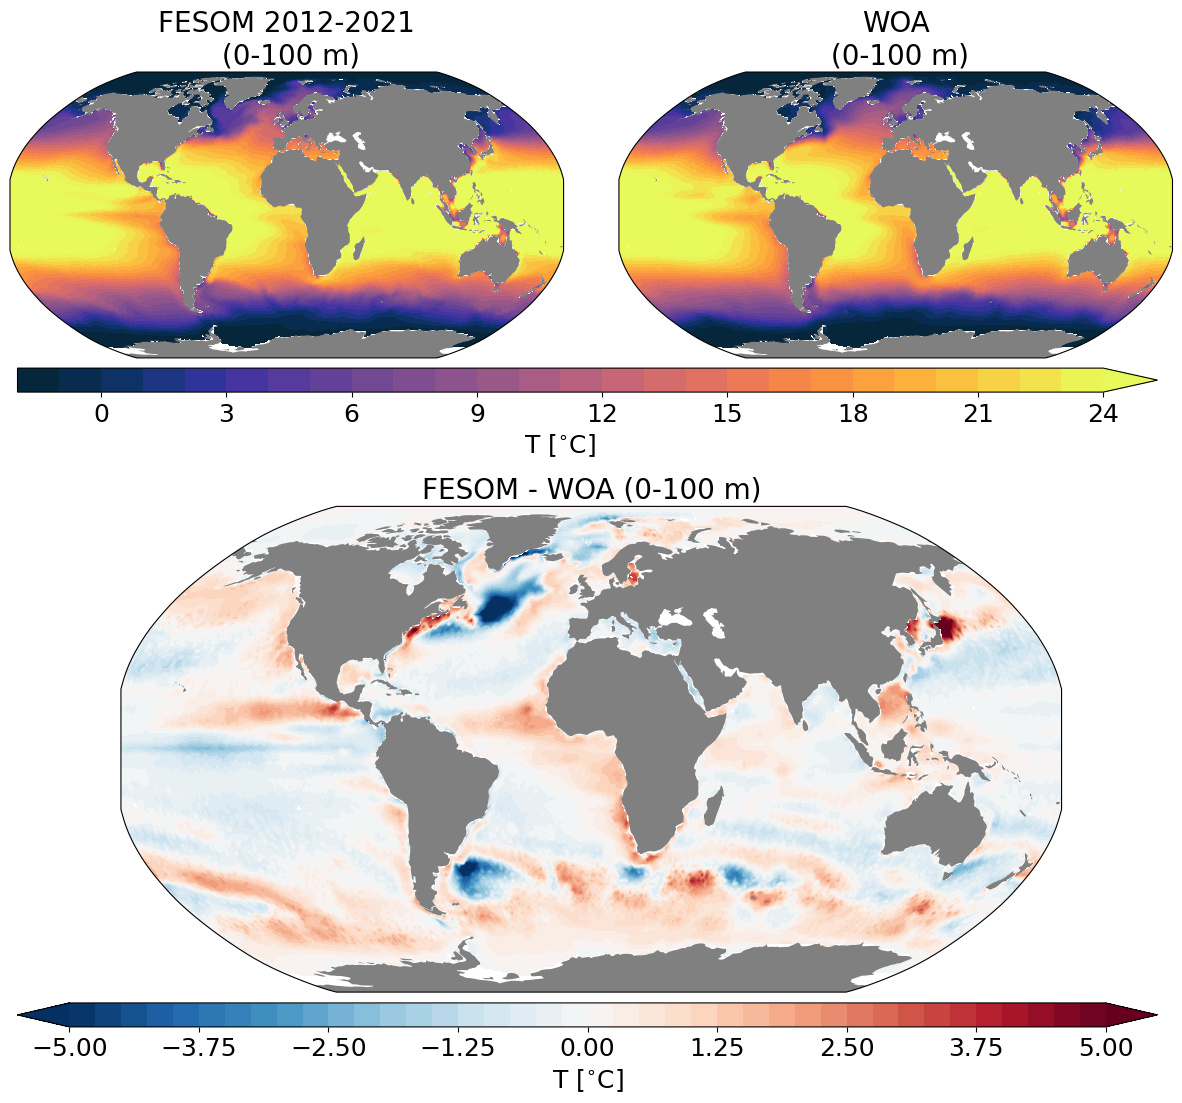


Original Taylor stats:
SDEV pred: 10.54785, ref: 10.60519
CRMS pred: 0.93938, ref: 0.00000
CORRCOEF: 0.99607

Normalized Taylor stats:
SDEV pred: 0.99459, ref: 1.00000
CRMS pred: 0.08858, ref: 0.00000
CORRCOEF: 0.99607


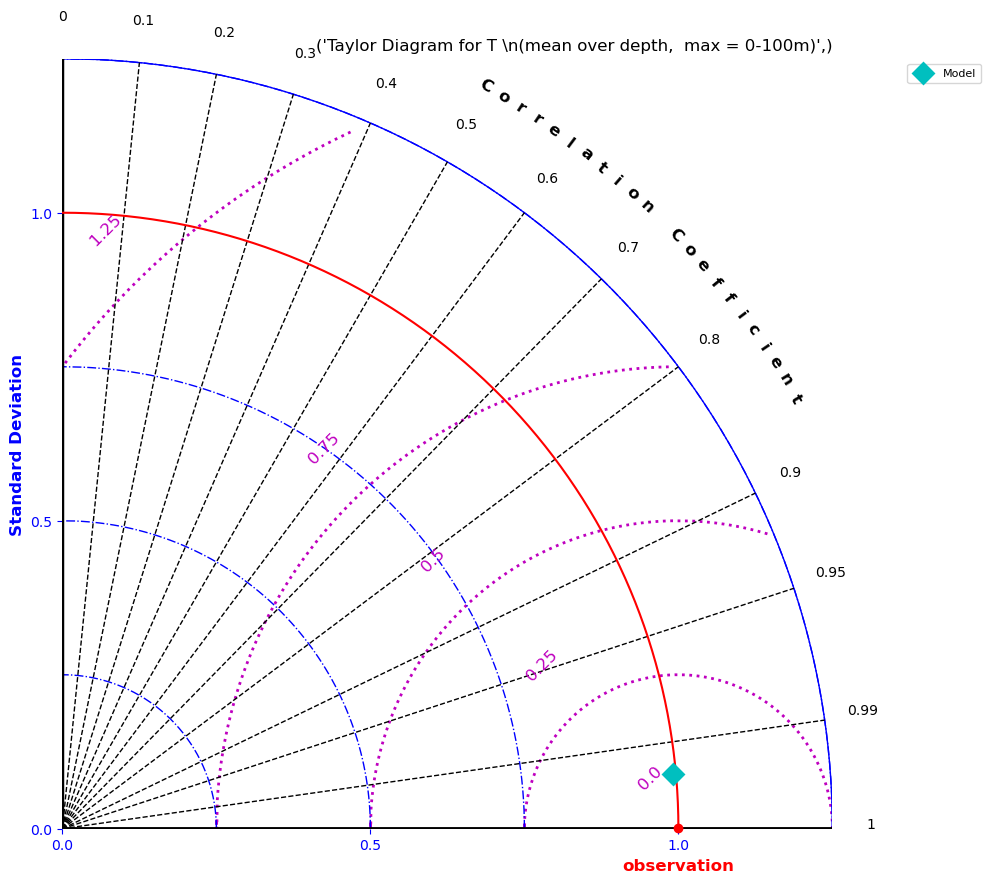

In [4]:
!jupyter nbconvert --to=python Temp_WOA.ipynb
!jupyter nbconvert --to=python load_interp_WOA.ipynb

from Temp_WOA import TEMPcomp
TEMPcomp(resultpath,savepath,mesh,ncfileTemp,first_year_maps,last_year,
                layerwise=layerwise,depth_array=depths,savefig=savefig, 
                cmap = cmo.cm.thermal,verbose=verbose)

# 1.1.2 Salinity<a class="anchor" id="SAL"></a>

#### PHC3<a class="anchor" id="SALPHC3MAPS"></a>

[NbConvertApp] Converting notebook TS_PHC3.ipynb to python
[NbConvertApp] Writing 49628 bytes to TS_PHC3.py
[NbConvertApp] Converting notebook load_interp_PHC.ipynb to python
[NbConvertApp] Writing 6771 bytes to load_interp_PHC.py
***
Loading PHC file: /albedo/work/projects/p_pool_recom/eval/phc3.0_annual.nc
***
***
Depth greater in FESOM (-6125.0) than in PHC (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 31.6335, std = 7.5932, min = 1.2085, max = 40.3237
PHC mean = 31.4652, std = 7.5409, min = 1.0779, max = 40.0972


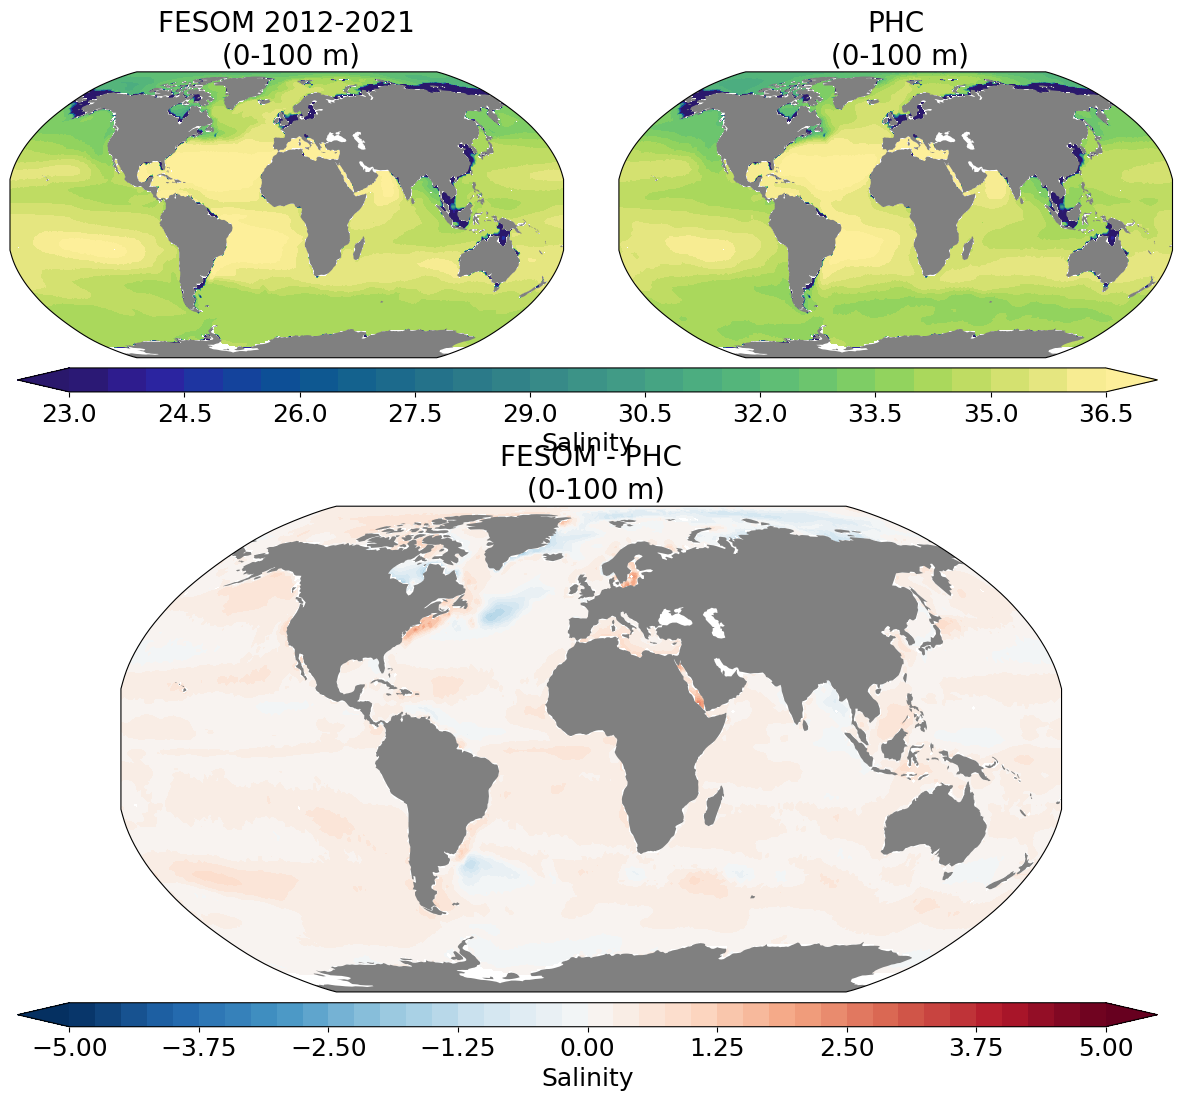


Original Taylor stats:
SDEV pred: 7.59321, ref: 7.54088
CRMS pred: 0.32132, ref: 0.00000
CORRCOEF: 0.99912

Normalized Taylor stats:
SDEV pred: 1.00694, ref: 1.00000
CRMS pred: 0.04261, ref: 0.00000
CORRCOEF: 0.99912
Adjust axis max to 1.5


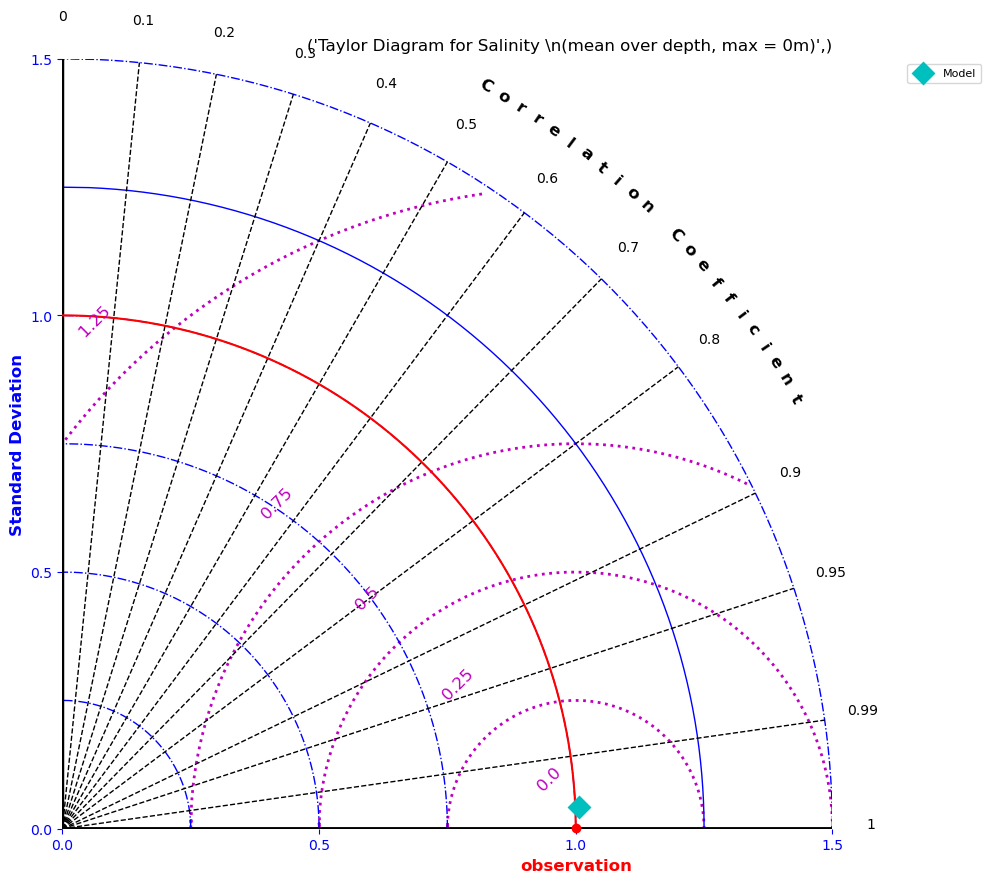

In [6]:
!jupyter nbconvert --to=python TS_PHC3.ipynb
!jupyter nbconvert --to=python load_interp_PHC.ipynb

from TS_PHC3 import PHC3salcomp
PHC3salcomp(resultpath,savepath,mesh,ncfilePHC3,first_year_maps,last_year,mapproj=mapproj,
                layerwise=layerwise,depth_array=0,savefig=savefig, 
                cmap = cmo.cm.haline,verbose=verbose)

#### WOA<a class="anchor" id="SALWOAMAPS"></a>

[NbConvertApp] Converting notebook Sal_WOA.ipynb to python
[NbConvertApp] Writing 16116 bytes to Sal_WOA.py
[NbConvertApp] Converting notebook load_interp_WOA.ipynb to python
[NbConvertApp] Writing 7253 bytes to load_interp_WOA.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_decav_s00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 31.6335, std = 7.5932, min = 1.2085, max = 40.3237
WOA mean = 31.4391, std = 7.5796, min = 1.5163, max = 40.2282


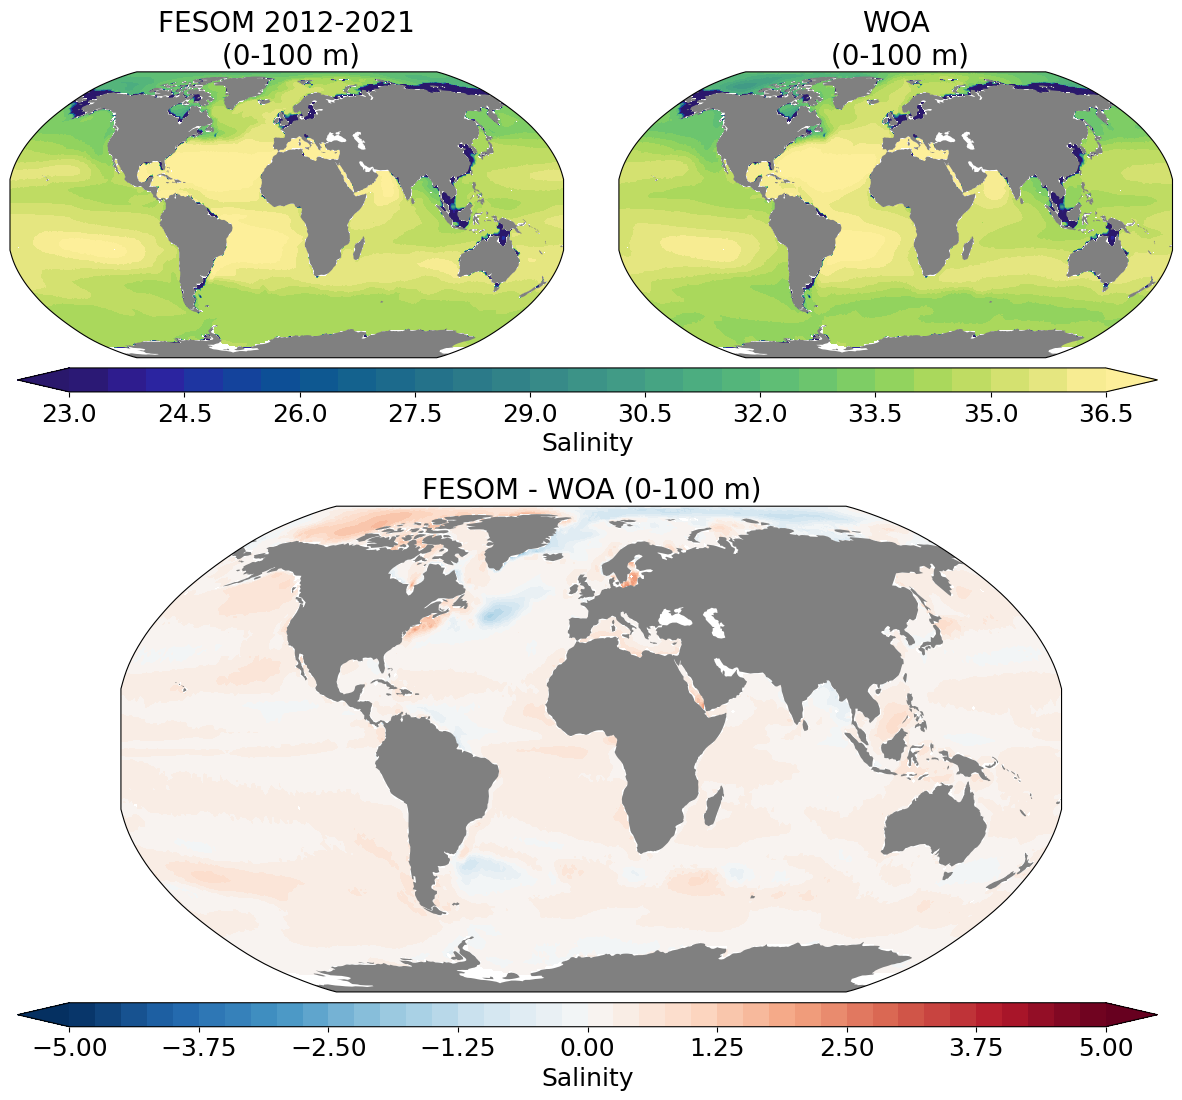


Original Taylor stats:
SDEV pred: 7.59321, ref: 7.57963
CRMS pred: 0.35843, ref: 0.00000
CORRCOEF: 0.99889

Normalized Taylor stats:
SDEV pred: 1.00179, ref: 1.00000
CRMS pred: 0.04729, ref: 0.00000
CORRCOEF: 0.99889
Adjust axis max to 1.5


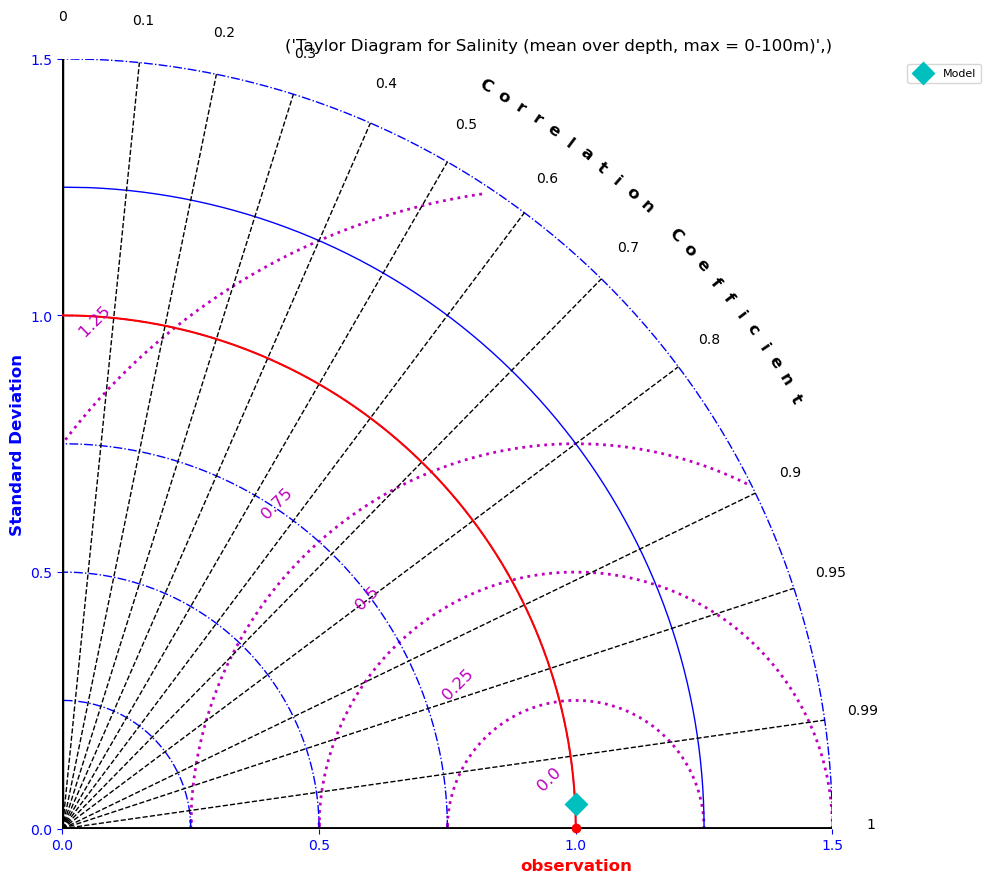

In [5]:
!jupyter nbconvert --to=python Sal_WOA.ipynb
!jupyter nbconvert --to=python load_interp_WOA.ipynb
from Sal_WOA import SALcomp

SALcomp(resultpath,savepath,mesh,ncfileSal,first_year_maps,last_year,mapproj=mapproj,
               layerwise=layerwise,depth_array=depths,savefig=savefig,
               cmap = cmo.cm.haline,verbose=verbose)

# 1.1.3 MLD<a class="anchor" id="MLD"></a>

[NbConvertApp] Converting notebook load_interp_MLD.ipynb to python
[NbConvertApp] Writing 4460 bytes to load_interp_MLD.py
[NbConvertApp] Converting notebook MLD.ipynb to python
[NbConvertApp] Writing 12697 bytes to MLD.py
Processing /albedo/work/projects/MarESys/GCB2022/A
***
Loading MLD file: /albedo/work/projects/p_pool_recom/eval/GlobalML_Climato_1970_2018.mat
***

Winter MLD
Atlas nmin = 7.1701, max = 3549.4575
FESOM min = 0.3850, max = 1265.9169

Summer MLD
Atlas nmin = 6.9231, max = 1229.9412
FESOM min = 0.3055, max = 6626.0366


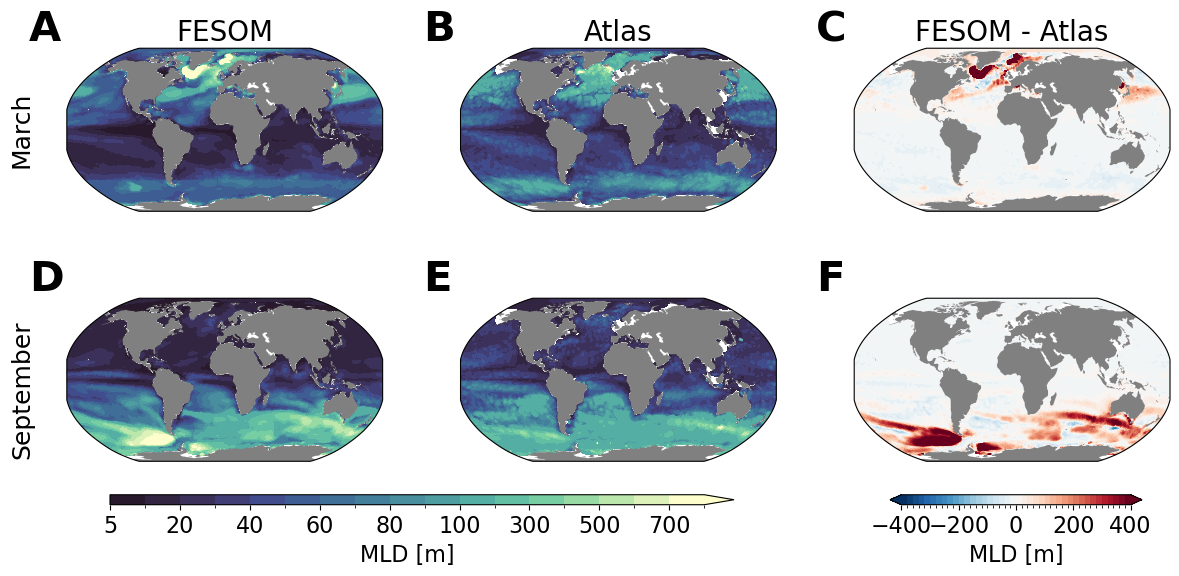

In [5]:
# In FESOM2-RECOM2, MLD2 is set to be density threshold of 0.03 kg/m3 like in de Boyer et al. (2004)
!jupyter nbconvert --to=python load_interp_MLD.ipynb
!jupyter nbconvert --to=python MLD.ipynb
from MLD import MLD_comp

MLD_comp(resultpath,savepath,mesh,matfileMLD,first_year_maps,last_year,
                 savefig=True, verbose=True, output=False, 
                            plotting=True, Taylor=True,cmap = cmo.cm.deep_r)

## 2.2 Profiles<a class="anchor" id="PHYPRO"></a>

[NbConvertApp] Converting notebook TS_profiles.ipynb to python
[NbConvertApp] Writing 14890 bytes to TS_profiles.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_decav_s00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_decav_t00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)


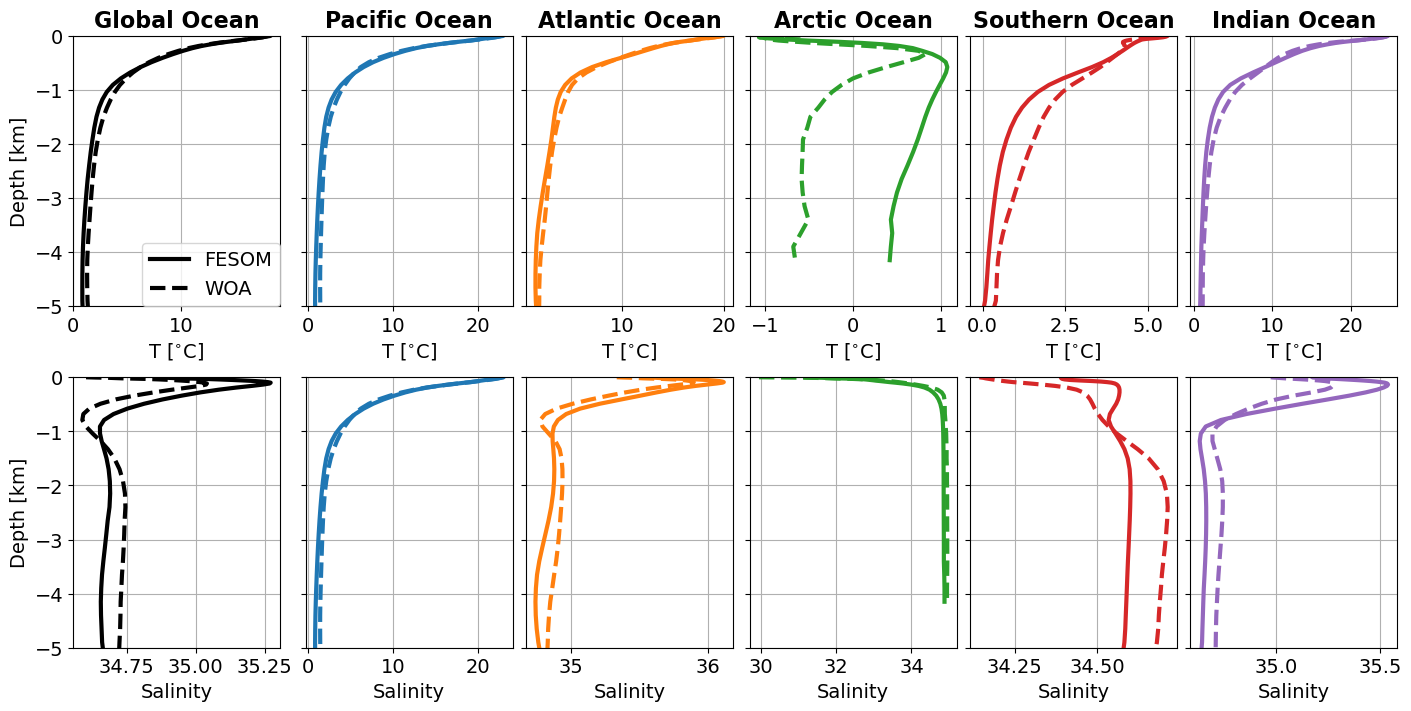

In [6]:
!jupyter nbconvert --to=python TS_profiles.ipynb
from TS_profiles import TS_profile

TS_profile(resultpath,savepath,mesh,ncfileTemp,ncfileSal,first_year_maps,last_year,
                 savefig=savefig, regional=True)

## 1.3 time series<a class="anchor" id="PHYTS"></a>

[NbConvertApp] Converting notebook SEAICE_timeseries.ipynb to python
[NbConvertApp] Writing 2865 bytes to SEAICE_timeseries.py
## Observations only for the 1979-2019 period ##


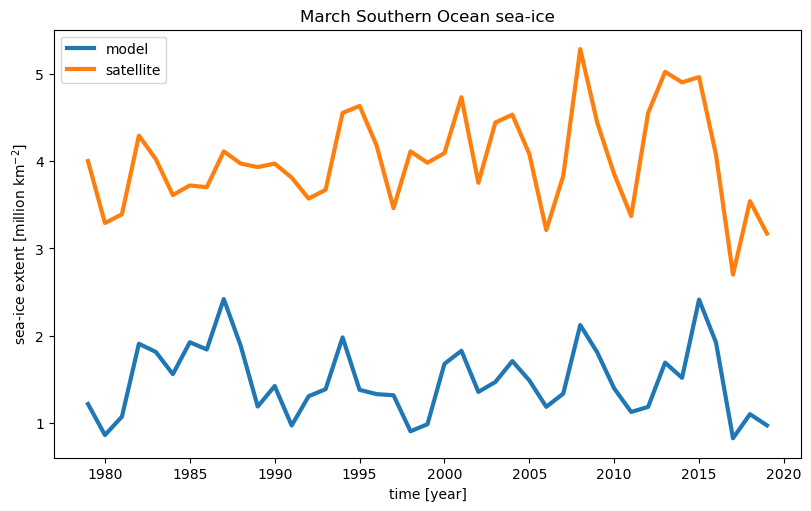

In [7]:
!jupyter nbconvert --to=python SEAICE_timeseries.ipynb
from SEAICE_timeseries import SEAICE_timeseries
SEAICE_timeseries(resultpath,savepath,mesh,ncfilesic,1979,2019,
                 savefig=False,regional='S',type = 'extent', plotting=True, output=False)

[NbConvertApp] Converting notebook SEAICE_timeseries.ipynb to python
[NbConvertApp] Writing 2865 bytes to SEAICE_timeseries.py
## Observations only for the 1979-2019 period ##


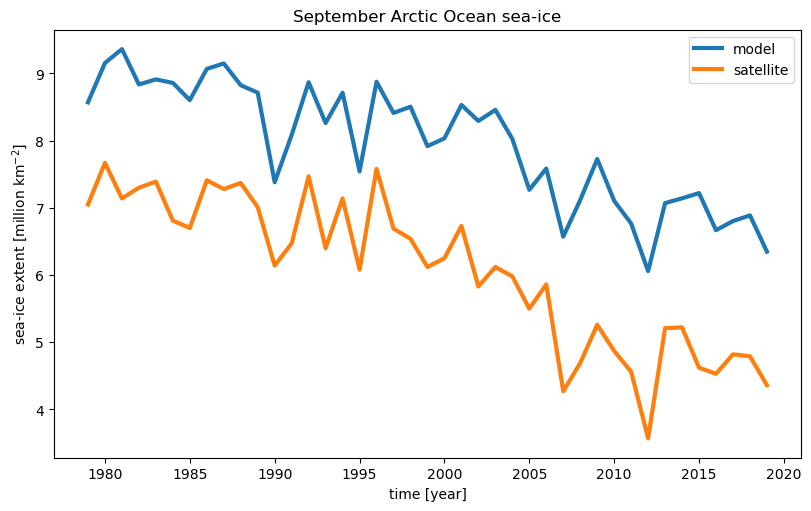

In [8]:
!jupyter nbconvert --to=python SEAICE_timeseries.ipynb
from SEAICE_timeseries import SEAICE_timeseries
SEAICE_timeseries(resultpath,savepath,mesh,ncfilesic,1979,2019,
                 savefig=False,regional='N',type = 'extent', plotting=True, output=False)

# Save notebook as html

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
%autosave 2
!jupyter nbconvert $nb_name --output-dir=$htmlpath --to html --no-input